# <center> ECS6P9U/P/7026P

# <center> NEURAL NETWORKS & DEEP LEARNING

<b><u>Author</u></b> : Lucas Berry

<b><u>Student id</u></b> : 220296948

# <b> Part 1. Read dataset and create data loaders

## <center> <b> --- Installation ---

In [ ]:
!pip3 install torch torchvision torchaudio # Install PyTorch, torchvision, and torchaudio libraries
print('\033[1m\033[92m' + 'Torch, torchvision and torchaudio are successfully installed' + '\033[0m')  

!pip install my_utils # Install the custom 'my_utils' library
print('\033[1m\033[92m' + 'My utils is successfully installed' + '\033[0m')  


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Torch, torchvision and torchaudio are successfully installed
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
My utils is successfully installed


## <center> <b> --- Libraries ---

In [ ]:
import my_utils as mu 
import torch 
import numpy as np 
import torchvision 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader #Part 1.
from torchvision import datasets #Part 1.
import torchvision.transforms as transforms #Part 1.
from torch import nn #Part 2.
import torch.optim as optim #Part 3.
from torch.optim.lr_scheduler import ReduceLROnPlateau #Part 3.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set the device (GPU or CPU)
print('Device:', device)

Device: cuda:0


## <center> <b> --- Data preprocessing ---

In [ ]:
# Define the transformations to be applied to the images

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Apply random cropping with padding
    transforms.RandomHorizontalFlip(p=0.5), # Apply random horizontal flip
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Apply random affine transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Apply random colour jitter
    transforms.ToTensor(), # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the tensor
])

transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

## <center> <b> --- Loading ---

In [ ]:
# Download and load CIFAR-10
traindataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train) # Download and load CIFAR-10 train dataset

trainset, valset = torch.utils.data.random_split(traindataset, [40000, 10000]) # Split the training dataset into train and validation sets

print('The length of the trainset is \033[1m\033[31m' + str(len(trainset)) + "\033[0m")  

print('The length of the valset is \033[1m\033[31m' + str(len(valset)) + "\033[0m")  

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test) # Download and load CIFAR-10 test dataset

print('The length of the testset is \033[1m\033[31m' + str(len(testset)) + "\033[0m")  

100%|██████████| 170498071/170498071 [00:03<00:00, 47631676.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
The length of the trainset is 40000
The length of the valset is 10000
Files already downloaded and verified
The length of the testset is 10000


In [ ]:
batch_size = 64 # Set the batch size
print("The batch size is \033[1m\033[31m"+ str(batch_size) + "\033[0m")  
num_workers = torch.cuda.device_count() # Get the number of workers as the number of available GPU devices
print("The number of workers is \033[1m\033[31m"+ str(num_workers) + "\033[0m")  

The batch size is 64
The number of workers is 1


In [ ]:
# Create data loaders for train, validation, and test sets

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=num_workers)

valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, 
                                        shuffle=False, num_workers=num_workers)

testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
# Define the class names

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

## <center> <b> --- Visualizations ---

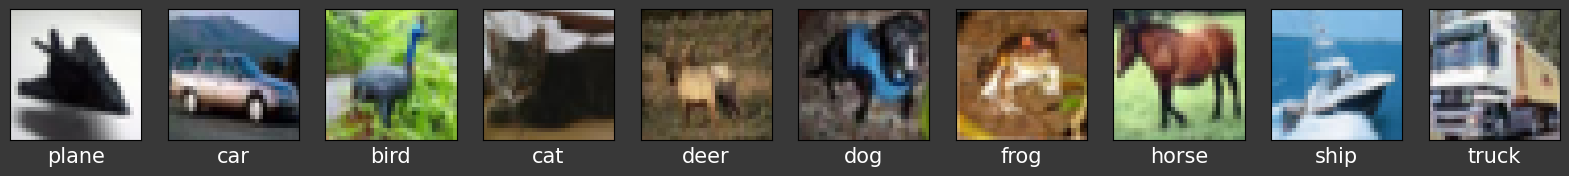

In [ ]:
# Define a function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()  # Convert the image to a NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose and display the image
    plt.show()

# Get the first image for each class in the dataset
sample_images = [traindataset.data[np.where(np.asarray(traindataset.targets) == label)[0][0]] for label in range(10)]

# Show images for each class
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
fig.set_facecolor('#383838')  # Set the face colour of the subplot
for i, ax in enumerate(axes.flat):  # Iterate through the axes
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_xlabel(classes[i], fontsize=15, color='White')  
    ax.imshow(sample_images[i])  
    ax.patch.set_alpha(0)  

plt.show()  


# <b> Part 2. The Model

## <center> <b> --- Architecture ---

In [ ]:
class Block(nn.Module):  # Define the custom block class
    def __init__(self, in_channels, out_channels, K, dropout_rate=0.5):
        super(Block, self).__init__()  
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Adaptive average pooling layer
        self.linear = nn.Linear(in_channels, K)  # Linear layer

        # Create a list of convolutional layers with batch normalisation, ReLU activation, dropout, and another convolutional layer

        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)) for _ in range(K)])
        self.shortcut = nn.Sequential()  # Shortcut connection
        if in_channels != out_channels:  # Check if input and output channels are different
            self.shortcut = nn.Sequential(  # Update the shortcut connection
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):  # Forward pass function
        a = self.avg_pool(x)  # Apply the adaptive average pooling
        a = a.view(a.size(0), -1)  # Flatten the tensor
        a = self.linear(a)  # Apply the linear layer
        a = torch.softmax(a, dim=1)  # Apply the softmax activation function

        out = torch.zeros_like(self.convs[0](x)).to(x.device)  # Initialise the output tensor

        for i, conv in enumerate(self.convs):  # Iterate through the convolutional layers
            out += a[:, i].view(-1, 1, 1, 1) * conv(x)  # Add the weighted output of each layer

        out += self.shortcut(x)  # Add the shortcut connection
        return self.relu(out)  # Apply the ReLU activation function 




class Backbone(nn.Module):  # Define the custom backbone class
    def __init__(self, in_channels, out_channels, K, N):
        super(Backbone, self).__init__()  
        # Create a sequence of blocks for the backbone
        self.blocks = nn.Sequential(*[Block(in_channels if i == 0 else out_channels, out_channels, K) for i in range(N)])

    def forward(self, x):  
        return self.blocks(x)  # Apply the blocks 




class Classifier(nn.Module):  # Define the custom classifier class
    def __init__(self, in_channels, num_classes):
        super(Classifier, self).__init__()  
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Adaptive average pooling layer
        self.fc = nn.Linear(in_channels, num_classes)  # Linear layer

    def forward(self, x):  
        x = self.avg_pool(x)  # Apply the adaptive average pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return self.fc(x)  # Apply the linear layer and return the output




class Net(nn.Module):  # Define the custom Net class
    def __init__(self, K, N, channels, num_classes=10):
        super(Net, self).__init__()  
        self.backbone = Backbone(3, channels, K, N)  # Instantiate the custom backbone
        self.classifier = Classifier(channels, num_classes)  # Instantiate the custom classifier

    def forward(self, x):  
        x = self.backbone(x)  # Apply the backbone to the input
        x = self.classifier(x)  # Apply the classifier to the output of the backbone
        return x  

## <center> <b> --- Model's complexity ---

In [ ]:
# Define K, N, and channels values

K = 3  # The number of parallel convolutional layers in each block
N = 3  # The number of blocks in the backbone
channels = 128  # The number of channels, it affects the model capacity

## <center> <b> --- Model's design  ---

In [ ]:
net = Net(K, N, channels).to(device)  # Instantiate the Net class and move it to the device 
print(net)

Net(
  (backbone): Backbone(
    (blocks): Sequential(
      (0): Block(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (linear): Linear(in_features=3, out_features=3, bias=True)
        (convs): ModuleList(
          (0-2): 3 x Sequential(
            (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Dropout(p=0.5, inplace=False)
            (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (shortcut): Sequential(
          (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): Block(
        (avg_pool): Adap

# <b> Part 3. Loss, Optimizer and Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()  # Use the cross-entropy loss 

optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0)  # Adam Optimizer with a learning rate of 0.01 and no weight decay

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)  # ReduceLROnPlateau scheduler reduces learning rate when validation loss plateaus

# <b> Part 4. Training and Evaluation



## <center> <b> --- Script ---

In [ ]:
num_epochs = 150  # Number of training epochs
patience = 10 # Early stopping parameters
counter = 0 # Early stopping parameters
best_val_loss = None # Early stopping parameters

# Initialise lists to store loss and accuracy values

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Function to calculate accuracy

def accuracy(output, target):
    _, pred = torch.max(output, 1)  # Get the class with the highest probability
    correct = pred.eq(target).sum().item()  # Count the number of correct predictions
    return correct / target.size(0)  # Calculate the accuracy and return it

for epoch in range(num_epochs):  # Loop through the number of epochs
    net.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss to 0
    running_acc = 0.0  # Initialize running accuracy to 0
    for i, (inputs, labels) in enumerate(trainloader, 0):  # Loop through batches of the training data
        inputs, labels = inputs.to(device), labels.to(device)  # Move the inputs and labels to the device

        optimizer.zero_grad()  # Set the gradients to zero

        outputs = net(inputs)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the model weights

        running_loss += loss.item()  # Update running loss
        running_acc += accuracy(outputs, labels)  # Update running accuracy

    train_loss = running_loss / (i + 1)  # Calculate the average training loss
    train_acc = running_acc / (i + 1)  # Calculate the average training accuracy

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop

    net.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss to 0
    running_val_acc = 0.0  
    with torch.no_grad():  # Disable gradient calculation to save memory and speed up the evaluation process
        for i, (inputs, labels) in enumerate(valloader, 0):  # Loop through batches of the validation data
            inputs, labels = inputs.to(device), labels.to(device)  # Move the inputs and labels to the device (GPU or CPU)

            outputs = net(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

            running_val_loss += loss.item()  # Update running validation loss
            running_val_acc += accuracy(outputs, labels)  # Update running validation accuracy

    val_loss = running_val_loss / (i + 1)  # Calculate the average validation loss
    val_acc = running_val_acc / (i + 1)  # Calculate the average validation accuracy

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update the learning rate using the scheduler

    scheduler.step(val_loss)  # Update learning rate based on the validation loss


    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if best_val_loss is None:
        best_val_loss = val_loss
    elif val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break   

Epoch 1/150, Train Loss: 1.7130, Train Acc: 0.3549, Val Loss: 1.5178, Val Acc: 0.4364
Epoch 2/150, Train Loss: 1.3774, Train Acc: 0.4981, Val Loss: 1.2711, Val Acc: 0.5290
Epoch 3/150, Train Loss: 1.2079, Train Acc: 0.5629, Val Loss: 1.2096, Val Acc: 0.5668
Epoch 4/150, Train Loss: 1.0889, Train Acc: 0.6073, Val Loss: 1.0145, Val Acc: 0.6382
Epoch 5/150, Train Loss: 1.0113, Train Acc: 0.6405, Val Loss: 0.9759, Val Acc: 0.6538
Epoch 6/150, Train Loss: 0.9474, Train Acc: 0.6648, Val Loss: 0.9051, Val Acc: 0.6794
Epoch 7/150, Train Loss: 0.8941, Train Acc: 0.6849, Val Loss: 0.9187, Val Acc: 0.6761
Epoch 8/150, Train Loss: 0.8486, Train Acc: 0.6989, Val Loss: 0.8240, Val Acc: 0.7105
Epoch 9/150, Train Loss: 0.8029, Train Acc: 0.7201, Val Loss: 0.8739, Val Acc: 0.6944
Epoch 10/150, Train Loss: 0.7716, Train Acc: 0.7272, Val Loss: 0.7927, Val Acc: 0.7222
Epoch 11/150, Train Loss: 0.7484, Train Acc: 0.7369, Val Loss: 0.7809, Val Acc: 0.7356
Epoch 12/150, Train Loss: 0.7148, Train Acc: 0.7500,

## <center> <b> --- Visualizations ---

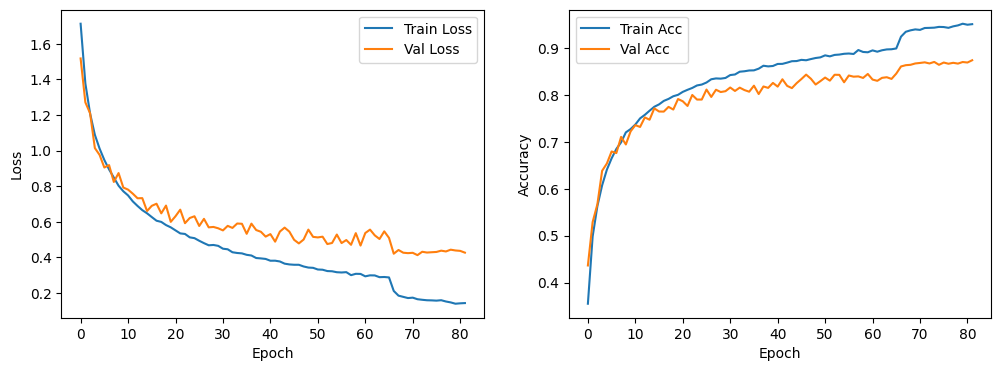

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## <center> <b> --- Accuracy ---

In [ ]:
pred_vec_train = []  # Initialise a list to store predicted labels for training set
correct_train = 0  # Initialise a counter for the number of correct predictions for training set
net.eval()  # Set the model to evaluation mode (disables dropout and batch normalisation during inference)

with torch.no_grad():  
    for data in trainloader:  # Iterate through the train dataset in batches
        batch, labels = data  # Split the data into inputs and ground truth labels
        batch, labels = batch.to(device), labels.to(device)  # Move the data to the target device 
        outputs = net(batch)  # Forward pass the inputs through the network to get the predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest score
        correct_train += (predicted == labels).sum().item()  # Increment the correct counter if the predicted class matches the ground truth label
        pred_vec_train.append(predicted)  # Append the predicted labels to the pred_vec_train list
    pred_vec_train = torch.cat(pred_vec_train)  # Concatenate the predicted labels into a single tensor

print('Train Accuracy: %.2f %%' % (100 * correct_train / len(trainset)))  # Calculate and print the accuracy on the train set


Train Accuracy: 96.78 %


# <b> Part 5. Testing

## <center> <b> --- Accuracy ---

In [ ]:
pred_vec = []  
correct = 0  
net.eval()  

with torch.no_grad():  
    for data in testloader:  
        batch, labels = data  
        batch, labels = batch.to(device), labels.to(device) 
        outputs = net(batch)  
        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()  
        pred_vec.append(predicted)  
    pred_vec = torch.cat(pred_vec)  

print('Test Accuracy: %.2f %%' % (100 * correct / len(testset)))  


Test Accuracy: 88.48 %


# <b> References

[1] PyTorch. 2021. PyTorch Documentation | PyTorch 1.9.1. [online] Available at: https://pytorch.org/docs/stable/index.html

[2] PyTorch. 2021. torchvision.datasets.CIFAR10 | PyTorch Vision 0.10.1. [online] Available at: https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10

[3] PyTorch. 2021. torch.optim.lr_scheduler.ReduceLROnPlateau | PyTorch 1.9.1. [online] Available at: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

[4] Educative. 2023. What is Early Stopping? | Educative. [online] Available at: https://www.educative.io/answers/what-is-early-stopping

[5] Analytics Vidhya. 2022. How to Classify the Images of the CIFAR-10 Dataset Using CNN | Analytics Vidhya. [online] Available at: https://www.analyticsvidhya.com/blog/2022/09/how-to-classify-the-images-of-the-cifar-10-dataset-using-cnn/#:~:text=CIFAR%2D10%20dataset%20comprises%2060%2C000,categories%20and%2010%2C000%20test%20images.